In [56]:
# Import necessary libraries and modules
import pandas as pd
import john_prepare as p
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


%load_ext autoreload
%autoreload 2

# Set the option to display all columns in DataFrames
pd.set_option('display.max_columns', None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
inspection_df = p.prepare_data('nyc_health_inspections_2000_to_2023.csv')
inspection_df.info()

TypeError: bad operand type for unary ~: 'float'

In [ ]:
inspection_df = p.prepare_data('nyc_health_inspections_2000_to_2023.csv')
inspection_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149937 entries, 0 to 207364
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   camis                  149937 non-null  int64  
 1   dba                    149937 non-null  object 
 2   boro                   149937 non-null  object 
 3   building               149937 non-null  object 
 4   street                 149937 non-null  object 
 5   zipcode                149937 non-null  object 
 6   phone                  149937 non-null  object 
 7   cuisine_description    149937 non-null  object 
 8   inspection_date        149937 non-null  object 
 9   action                 149937 non-null  object 
 10  critical_flag          149937 non-null  object 
 11  score                  149937 non-null  int32  
 12  record_date            149937 non-null  object 
 13  inspection_type        149937 non-null  object 
 14  latitude               149937 non-null  f

In [58]:
violation_df = pd.read_csv('ViolationData.csv')
violation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   violation_code     263 non-null    object
 1   violation_summary  263 non-null    object
dtypes: object(2)
memory usage: 4.2+ KB


In [63]:
# Remove duplicates from violation_df based on 'violation_code'
violation_df.drop_duplicates(subset='violation_code', inplace=True)

# Add a new column 'violation_summary' to inspection_df based on matching violation_code using violation_df
inspection_df['violation_summary'] = inspection_df['violation_code'].map(violation_df.set_index('violation_code')['violation_summary'])
inspection_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149937 entries, 0 to 207364
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   camis                  149937 non-null  int64  
 1   dba                    149937 non-null  object 
 2   boro                   149937 non-null  object 
 3   building               149937 non-null  object 
 4   street                 149937 non-null  object 
 5   zipcode                149937 non-null  object 
 6   phone                  149937 non-null  object 
 7   cuisine_description    149937 non-null  object 
 8   inspection_date        149937 non-null  object 
 9   action                 149937 non-null  object 
 10  critical_flag          149937 non-null  object 
 11  score                  149937 non-null  int32  
 12  record_date            149937 non-null  object 
 13  inspection_type        149937 non-null  object 
 14  latitude               149937 non-null  f

In [64]:
inspection_df.violation_code.nunique()

73

In [7]:
# Find inspections with duplicate violation codes
inspections_with_duplicates = inspection_df[inspection_df.duplicated(subset=['camis', 'inspection_date', 'violation_code'], keep=False)]

# Print the inspections with duplicate violation codes
inspections_with_duplicates


,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,critical_flag,score,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,violation_code,violation_description


In [8]:
# Group by 'camis' and 'inspection_date' and check if there are different scores within each group
inspections_with_different_scores = inspection_df.groupby(['camis', 'inspection_date'])['score'].transform('nunique') > 1

# Select rows of inspections with different scores
inspections_with_different_scores = inspection_df[inspections_with_different_scores]

# Print the inspections with different scores
inspections_with_different_scores


,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,critical_flag,score,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,violation_code,violation_description


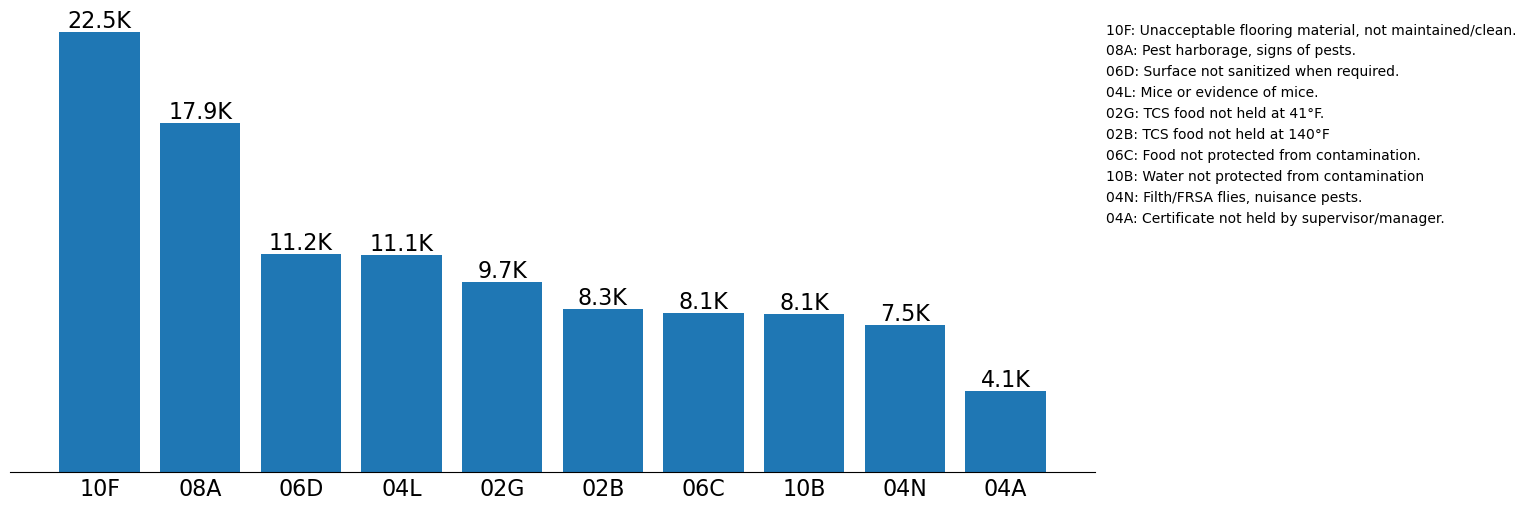

In [72]:
# Counting top 10 violations
violation_counts = inspection_df['violation_code'].value_counts().head(10)

# Creating the plot
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(violation_counts.index, violation_counts.values)

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(rotation=0, ha="center", fontsize=16)

# Adding values on top of bars
for bar in bars:
    height = bar.get_height()
    if height > 1000:
        text_label = f'{height / 1000:.1f}K'
    else:
        text_label = str(int(round(height / 10) * 10))
    
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, text_label,
            ha='center', va='bottom', fontsize=16)

# Creating a custom legend
# Create a dictionary mapping violation codes to summaries
violation_summary_dict = inspection_df.drop_duplicates('violation_code').set_index('violation_code')['violation_summary'].to_dict()
legend_patches = [mpatches.Patch(color='none', label=f'{code}: {violation_summary_dict[code]}') for code in violation_counts.index]
plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.4, 1), frameon=False)

plt.show()


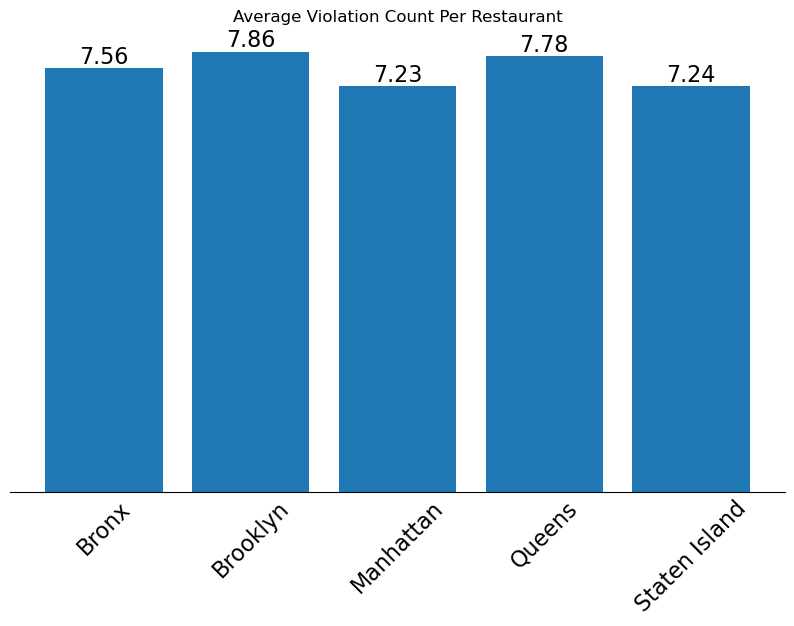

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate the number of restaurants in each borough
num_restaurants_per_boro = inspection_df.groupby('boro')['camis'].nunique()

# Step 2: Calculate the total number of violations in each borough
total_violations_per_boro = inspection_df.groupby('boro').size()

# Step 3: Normalize the violation counts
normalized_violations = total_violations_per_boro / num_restaurants_per_boro

# Step 4: Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(normalized_violations.index, normalized_violations.values)

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(rotation=45, ha="center", fontsize=16)

# Adding values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
            ha='center', va='bottom', fontsize=16)

plt.title('Average Violation Count Per Restaurant')
plt.show()


In [78]:
num_restaurants_per_boro

boro
Bronx            1812
Brooklyn         5181
Manhattan        7626
Queens           4497
Staten Island     741
Name: camis, dtype: int64

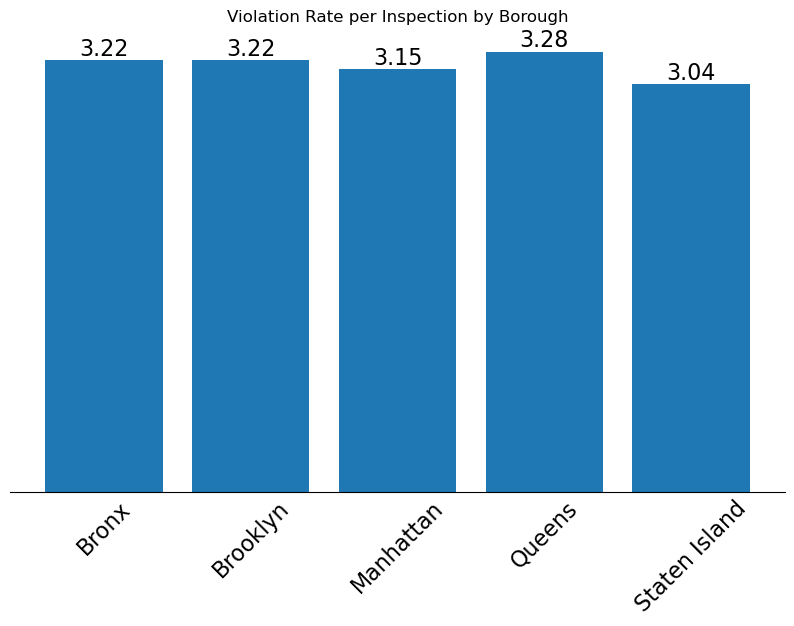

In [79]:
# Step 1: Calculate the total number of violations per borough
total_violations_per_boro = inspection_df.groupby('boro').size()

# Step 2: Calculate the total number of unique inspections per borough
# Each unique combination of camis and inspection_date represents a unique inspection
total_inspections_per_boro = inspection_df.groupby('boro').apply(lambda x: x.drop_duplicates(['camis', 'inspection_date']).shape[0])

# Step 3: Calculate Violation Rate per Inspection
violation_rate_per_inspection = total_violations_per_boro / total_inspections_per_boro

# Step 4: Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(violation_rate_per_inspection.index, violation_rate_per_inspection.values)

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(rotation=45, ha="center", fontsize=16)

# Adding values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
            ha='center', va='bottom', fontsize=16)

plt.title('Violation Rate per Inspection by Borough')
plt.show()


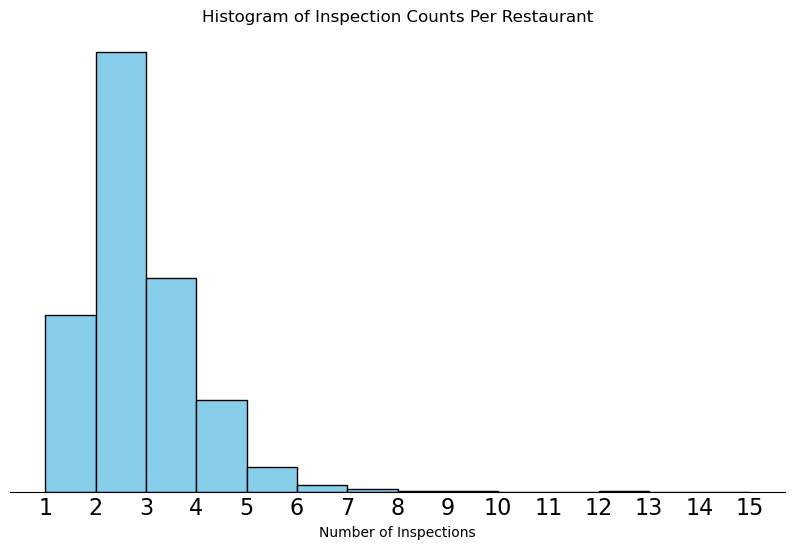

In [86]:
# Counting the number of inspections for each restaurant
inspections_per_restaurant = inspection_df.groupby('camis')['inspection_date'].nunique()

# Creating the histogram
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(inspections_per_restaurant, bins=range(1, inspections_per_restaurant.max() + 1), color='skyblue', edgecolor='black')

# Customizing the plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(range(1, inspections_per_restaurant.max() + 1), fontsize=16)
plt.xlabel('Number of Inspections')
plt.ylabel('Number of Restaurants')
plt.title('Histogram of Inspection Counts Per Restaurant')

plt.show()


In [87]:
inspection_df.inspection_type.unique()

array(['Inter-Agency Task Force / Initial Inspection',
       'Cycle Inspection / Initial Inspection',
       'Cycle Inspection / Reopening Inspection',
       'Cycle Inspection / Re-inspection',
       'Cycle Inspection / Compliance Inspection',
       'Cycle Inspection / Second Compliance Inspection',
       'Inter-Agency Task Force / Re-inspection'], dtype=object)

In [90]:
# Count inspections by unique values in the 'inspection_type' column
inspection_counts_by_type = inspection_df['inspection_type'].value_counts()
inspection_counts_by_type, inspection_counts_by_type.sum()

(inspection_type
 Cycle Inspection / Initial Inspection              110859
 Cycle Inspection / Re-inspection                    36611
 Cycle Inspection / Reopening Inspection              1378
 Cycle Inspection / Compliance Inspection              751
 Inter-Agency Task Force / Initial Inspection          304
 Cycle Inspection / Second Compliance Inspection        33
 Inter-Agency Task Force / Re-inspection                 1
 Name: count, dtype: int64,
 149937)

In [91]:
# Then we count the inspections by inspection_type
unique_inspections = inspection_df.drop_duplicates(subset=['camis', 'inspection_date'])
inspection_counts_by_type = unique_inspections['inspection_type'].value_counts()
inspection_counts_by_type


inspection_type
Cycle Inspection / Initial Inspection              34021
Cycle Inspection / Re-inspection                   11685
Cycle Inspection / Reopening Inspection              752
Cycle Inspection / Compliance Inspection             210
Inter-Agency Task Force / Initial Inspection         152
Cycle Inspection / Second Compliance Inspection        9
Inter-Agency Task Force / Re-inspection                1
Name: count, dtype: int64

In [92]:
# Convert 'inspection_date' to datetime if it's not already
inspection_df['inspection_date'] = pd.to_datetime(inspection_df['inspection_date'])

# Get the first inspection date for each restaurant
first_inspection_per_restaurant = inspection_df.groupby('camis')['inspection_date'].min()

# Calculate the age of each restaurant by subtracting the first inspection date from the current date
restaurant_ages = (pd.to_datetime('today') - first_inspection_per_restaurant).dt.days // 365

# Count the number of restaurants by age
restaurants_by_age = restaurant_ages.value_counts().sort_index()
restaurants_by_age


inspection_date
0     3010
1    10236
2     3171
3     1658
4     1312
5       93
6      271
7      101
8        5
Name: count, dtype: int64

In [96]:
all_inspections_df = pd.read_csv('nyc_health_inspections_2000_to_2023.csv')
all_inspections_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207365 entries, 0 to 207364
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   camis                  207365 non-null  int64  
 1   dba                    207365 non-null  object 
 2   boro                   207365 non-null  object 
 3   building               207076 non-null  object 
 4   street                 207365 non-null  object 
 5   zipcode                204723 non-null  float64
 6   phone                  207359 non-null  object 
 7   cuisine_description    207365 non-null  object 
 8   inspection_date        207365 non-null  object 
 9   action                 207365 non-null  object 
 10  critical_flag          207365 non-null  object 
 11  score                  199793 non-null  float64
 12  record_date            207365 non-null  object 
 13  inspection_type        207365 non-null  object 
 14  latitude               207119 non-nu

In [95]:
# Convert 'inspection_date' to datetime if it's not already
all_inspections_df['inspection_date'] = pd.to_datetime(all_inspections_df['inspection_date'])

# Get the first inspection date for each restaurant
first_inspection_per_restaurant = all_inspections_df.groupby('camis')['inspection_date'].min()

# Calculate the age of each restaurant by subtracting the first inspection date from the current date
restaurant_ages = (pd.to_datetime('today') - first_inspection_per_restaurant).dt.days // 365

# Count the number of restaurants by age
restaurants_by_age = restaurant_ages.value_counts().sort_index()
restaurants_by_age


inspection_date
0     5266
1    11588
2     4978
3     2013
4     1529
5      128
6      329
7      181
8        6
Name: count, dtype: int64

In [93]:
# Get the first inspection date for each restaurant
first_inspection_per_restaurant = inspection_df.groupby('camis')['inspection_date'].min()

# Find the oldest restaurant by getting the earliest date in the series
oldest_restaurant_date = first_inspection_per_restaurant.min()

# Get the year of the oldest restaurant
oldest_restaurant_year = oldest_restaurant_date.year
oldest_restaurant_year

2015

In [89]:
inspection_df.camis.nunique()

19857

In [84]:
# Step 1: Group by borough and restaurant, then count unique inspections for each restaurant
inspections_per_restaurant_per_boro = inspection_df.groupby(['boro', 'camis'])['inspection_date'].nunique()

# Step 2: Calculate the average number of inspections per restaurant for each borough
average_inspections_per_restaurant_per_boro = inspections_per_restaurant_per_boro.groupby('boro').mean()

print(average_inspections_per_restaurant_per_boro)


boro
Bronx            2.348234
Brooklyn         2.442772
Manhattan        2.293863
Queens           2.370247
Staten Island    2.384615
dtype: float64


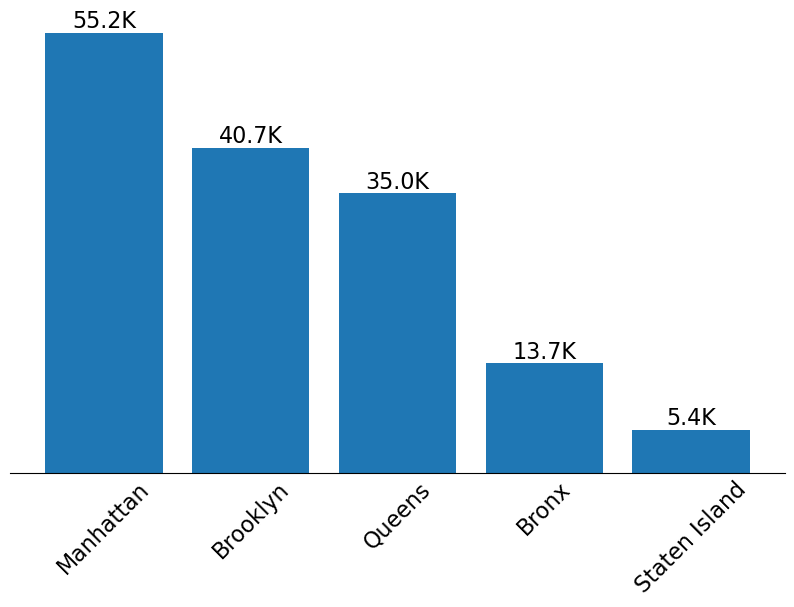

In [71]:
borough_counts = inspection_df['boro'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(borough_counts.index, borough_counts.values)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
ax.tick_params(axis='x', length=0)
plt.xticks(rotation=45, ha="center", fontsize=16)

for bar in bars:
    height = bar.get_height()
    if height > 1000:
        text_label = f'{height / 1000:.1f}K'
    else:
        text_label = str(int(round(height / 10) * 10))
    
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, text_label,
            ha='center', va='bottom', fontsize=16)

plt.show()


In [11]:
# Calculate unique inspections by grouping by 'camis' and 'inspection_date'
unique_inspections = inspection_df.groupby(['camis', 'inspection_date']).size().reset_index(name='inspection_count')

# Get the distribution of boroughs for these unique inspections
borough_counts = unique_inspections['boro'].value_counts()

plt.figure(figsize=(10, 6))
ax = borough_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Restaurants by Borough for Unique Inspections')
plt.xticks(rotation=45)

# Display borough names on the bars
ax.set_xticklabels(borough_counts.index, rotation=45)

# Remove Y-axis
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', left=False, labelleft=False)

# Remove the square around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove the horizontal X line
ax.spines['bottom'].set_visible(False)

# Remove X ticks
plt.xticks([])

# Remove X and Y labels
plt.xlabel('')
plt.ylabel('')

# Add values at the top of the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

KeyError: 'boro'

In [12]:
unique_inspections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46830 entries, 0 to 46829
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   camis             46830 non-null  int64 
 1   inspection_date   46830 non-null  object
 2   inspection_count  46830 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB
